**Loading and Exploring the dataset**

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load datasets
train_path = 'fruit_dataset/train'
test_path = 'fruit_dataset/test'

#automatically labels the images based on folder names.
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# DataLoaders helps in batching, shuffling, and loading images efficiently.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class labels
class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']


Visualizing images

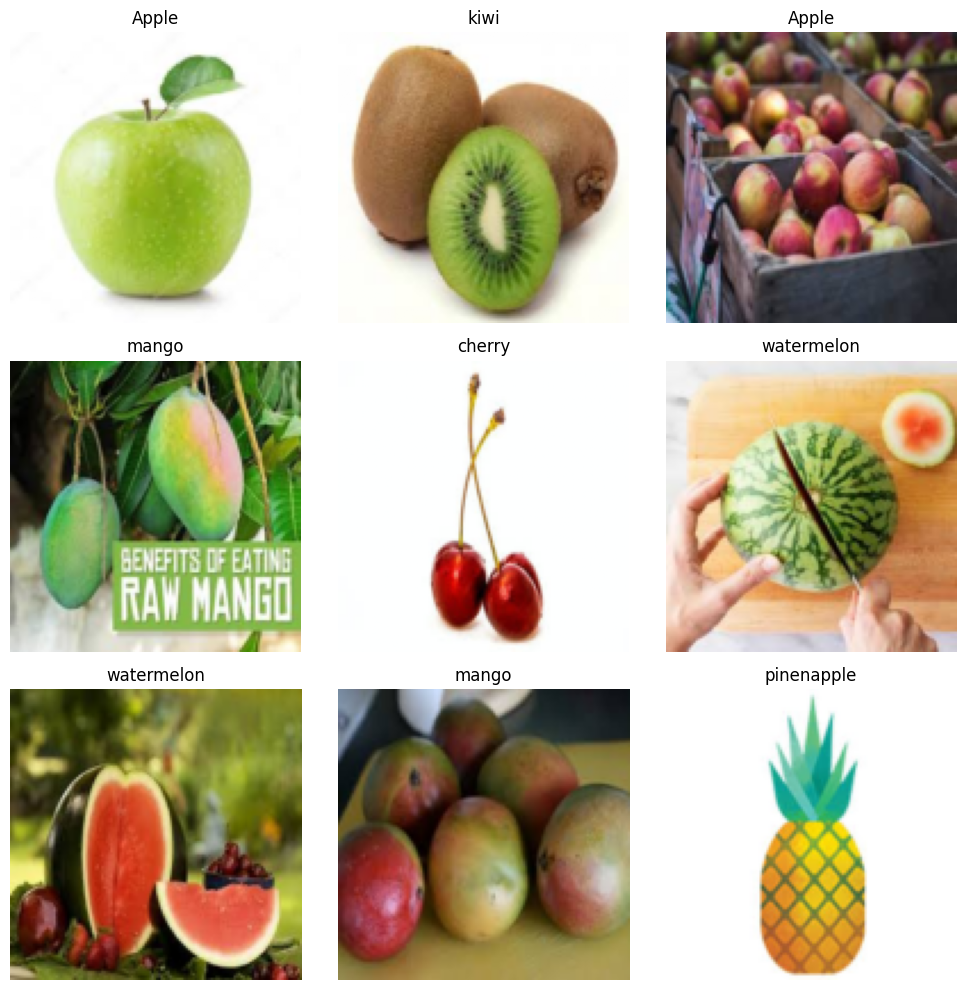

In [4]:
# Visualize a few training images
import numpy as np

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor to numpy format
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 10))
for idx in range(9):
    plt.subplot(3, 3, idx+1)
    imshow(images[idx], class_names[labels[idx]])
plt.tight_layout()
plt.show()


Counting Images

In [5]:
from collections import Counter

labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count} images")


Apple: 230 images
Banana: 230 images
avocado: 230 images
cherry: 230 images
kiwi: 230 images
mango: 231 images
orange: 230 images
pinenapple: 230 images
strawberries: 230 images
watermelon: 230 images


set image size

In [6]:
from PIL import Image

image_sizes = []
for img_path, _ in train_dataset.samples[:100]:
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

print(set(image_sizes))


{(273, 185), (289, 175), (274, 184), (180, 180), (281, 180), (285, 177), (205, 246), (270, 186), (259, 195), (318, 159), (269, 187), (200, 252), (201, 251), (203, 248), (268, 188), (221, 229), (223, 226), (301, 167), (321, 157), (310, 163), (183, 275), (300, 168), (184, 274), (222, 227), (259, 194), (320, 158), (280, 180), (248, 203), (253, 199), (242, 208), (224, 224), (271, 186), (276, 182), (247, 204), (236, 213), (284, 177), (235, 214), (225, 225), (299, 168), (290, 174), (275, 183), (262, 192), (251, 201), (261, 193), (239, 211)}


Data Cleaning 

In [7]:
from PIL import UnidentifiedImageError

bad_images = []
for img_path, _ in train_dataset.samples:
    try:
        with Image.open(img_path) as img:
            img.verify()
    except (UnidentifiedImageError, IOError):
        bad_images.append(img_path)

print(f"Found {len(bad_images)} bad images")


Found 0 bad images


Defining a CNN model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Applies a 2D convolution to extract features from the image
        # 3 is for rgb, 32 filters for 32 feature maps, kernel size 3x3, padding 1 to keep the same spatial dimensions(ensure output size is same as input size)
        # max pooling reduces(downsample) the spatial dimensions by half (2x2 pooling)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # input images are resized to 128x128
        # fc1 converts the 2D feature maps into a 1D vector
        # fc2 Final output layer — outputs one value for each class
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # after 2 poolings: 128 -> 64 -> 32
        self.fc2 = nn.Linear(128, num_classes)

    # defines how the data flows through the network
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # First block extracts features and reduces size
        x = self.pool2(F.relu(self.conv2(x)))  # More complex features and further size reduction
        x = x.view(-1, 64 * 32 * 32)           # Flattens the output to a vector for the dense layer
        x = F.relu(self.fc1(x))                # fully connected hidden layer
        x = self.fc2(x)                        # Outputs logits (raw scores) for each class        
        return x

# We don’t apply Softmax here, because nn.CrossEntropyLoss() expects raw logits and internally applies it.

What Happens to an Image (128×128)?

conv1: Input [3, 128, 128] → Output [32, 128, 128]

pool1: [32, 128, 128] → [32, 64, 64]

conv2: [32, 64, 64] → [64, 64, 64]

pool2: [64, 64, 64] → [64, 32, 32]

Flatten: 64*32*32 = 65536 features

fc1: 65536 → 128

fc2: 128 → num_classes

**Setup a training loop**

In [9]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training the model

In [10]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


In [15]:
train(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10], Loss: 0.6387, Accuracy: 77.79%
Epoch [2/10], Loss: 0.4371, Accuracy: 85.79%
Epoch [3/10], Loss: 0.2632, Accuracy: 92.09%
Epoch [4/10], Loss: 0.1237, Accuracy: 97.39%
Epoch [5/10], Loss: 0.0744, Accuracy: 98.44%
Epoch [6/10], Loss: 0.0313, Accuracy: 99.52%
Epoch [7/10], Loss: 0.0135, Accuracy: 99.87%
Epoch [8/10], Loss: 0.0075, Accuracy: 99.96%
Epoch [9/10], Loss: 0.0045, Accuracy: 99.96%
Epoch [10/10], Loss: 0.0032, Accuracy: 99.96%


Test the model

In [16]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [17]:
evaluate(model, test_loader)

Test Accuracy: 51.22%


Confusion matrix

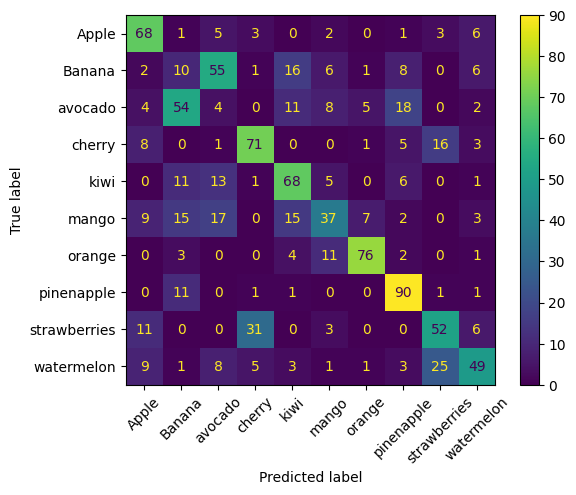

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.show()


In [19]:
torch.save(model.state_dict(), 'fruit_model.pth')